In [33]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import OneHotEncoder
import ast
import wfdb
from wfdb import io, processing, plot, rdsamp, rdrecord

from pathlib import Path
import os
import requests
import zipfile
import plotly.graph_objects as go
import plotly.express as px
import neurokit2 as nk
from ecgdetectors import Detectors

from doppelganger.utils import load_raw_data, plot_and_rates, vals_from_ecg

## Allow "hot-reloading" of modules
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
path = "/Users/sbenson/Documents/Datasets/ptb-xl-ecg/"
data_loc = path+"ptbxl_database.csv"
# Load scp_statements.csv for diagnostic aggregation
agg_df = pd.read_csv(path+'scp_statements.csv', index_col=0)
agg_df = agg_df[agg_df.diagnostic == 1]

df = pd.read_csv(data_loc)
print(len(df))
print(df.columns)
print(df.head())


21799
Index(['ecg_id', 'patient_id', 'age', 'sex', 'height', 'weight', 'nurse',
       'site', 'device', 'recording_date', 'report', 'scp_codes', 'heart_axis',
       'infarction_stadium1', 'infarction_stadium2', 'validated_by',
       'second_opinion', 'initial_autogenerated_report', 'validated_by_human',
       'baseline_drift', 'static_noise', 'burst_noise', 'electrodes_problems',
       'extra_beats', 'pacemaker', 'strat_fold', 'filename_lr', 'filename_hr'],
      dtype='object')
   ecg_id  patient_id   age  sex  height  weight  nurse  site     device  \
0       1     15709.0  56.0    1     NaN    63.0    2.0   0.0  CS-12   E   
1       2     13243.0  19.0    0     NaN    70.0    2.0   0.0  CS-12   E   
2       3     20372.0  37.0    1     NaN    69.0    2.0   0.0  CS-12   E   
3       4     17014.0  24.0    0     NaN    82.0    2.0   0.0  CS-12   E   
4       5     17448.0  19.0    1     NaN    70.0    2.0   0.0  CS-12   E   

        recording_date  ... validated_by_human  baseli

In [3]:
print(df[["scp_codes"]].value_counts())

scp_codes                                                                
{'NORM': 100.0, 'SR': 0.0}                                                   6142
{'NORM': 80.0, 'SR': 0.0}                                                     722
{'NDT': 100.0, 'SR': 0.0}                                                     633
{'LAFB': 100.0, 'SR': 0.0}                                                    277
{'PACE': 100.0}                                                               272
                                                                             ... 
{'ILMI': 50.0, 'ASMI': 50.0, 'SR': 0.0}                                         1
{'ILMI': 50.0, 'ASMI': 50.0, 'LAFB': 100.0, 'STD_': 0.0, 'AFIB': 0.0}           1
{'ILMI': 50.0, 'ASMI': 50.0, 'LAFB': 100.0, 'SR': 0.0}                          1
{'ILMI': 50.0, 'ASMI': 50.0, 'LAFB': 100.0, 'INJAL': 100.0, 'SVARR': 0.0}       1
{'WPW': 50.0, 'SR': 0.0}                                                        1
Name: count, Length: 546

In [4]:
# print NaNs per column
print(df.isnull().sum())

ecg_id                              0
patient_id                          0
age                                 0
sex                                 0
height                          14825
weight                          12378
nurse                            1473
site                               17
device                              0
recording_date                      0
report                              0
scp_codes                           0
heart_axis                       8468
infarction_stadium1             16187
infarction_stadium2             21696
validated_by                     9378
second_opinion                      0
initial_autogenerated_report        0
validated_by_human                  0
baseline_drift                  20201
static_noise                    18539
burst_noise                     21186
electrodes_problems             21769
extra_beats                     19850
pacemaker                       21508
strat_fold                          0
filename_lr 

In [5]:
df["scp_codes"].nunique()

5463

In [6]:
df.scp_codes = df.scp_codes.apply(lambda x: ast.literal_eval(x))

In [7]:
def aggregate_diagnostic(y_dic):
    tmp = []
    for key in y_dic.keys():
        if key in agg_df.index:
            tmp.append(agg_df.loc[key].diagnostic_class)
    return list(set(tmp))
df['diagnostic_superclass'] = df.scp_codes.apply(aggregate_diagnostic)

In [8]:
# Make function that returns 0 if norm, 1 if MI, and -1 if neither
def norm_vs_mi(x):
    # diag superclass
    diags = x["diagnostic_superclass"]
    l_diags = [d.lower() for d in diags]
    if "norm" in l_diags:
        return 0
    elif "mi" in l_diags:
        return 1
    else:
        return -1
df["norm_vs_mi"] = df.apply(norm_vs_mi, axis=1)

In [9]:
# restrict to norm or mi
df_NvsMI = df[df["norm_vs_mi"]>-0.5]
print(df_NvsMI.shape)

(14982, 30)


In [10]:
print(df_NvsMI.columns)

Index(['ecg_id', 'patient_id', 'age', 'sex', 'height', 'weight', 'nurse',
       'site', 'device', 'recording_date', 'report', 'scp_codes', 'heart_axis',
       'infarction_stadium1', 'infarction_stadium2', 'validated_by',
       'second_opinion', 'initial_autogenerated_report', 'validated_by_human',
       'baseline_drift', 'static_noise', 'burst_noise', 'electrodes_problems',
       'extra_beats', 'pacemaker', 'strat_fold', 'filename_lr', 'filename_hr',
       'diagnostic_superclass', 'norm_vs_mi'],
      dtype='object')


In [11]:
# get first 100 rows of data
df_100 = df_NvsMI.head(100)

In [12]:
print(df_100[["filename_lr", "filename_hr"]])

                   filename_lr                filename_hr
0    records100/00000/00001_lr  records500/00000/00001_hr
1    records100/00000/00002_lr  records500/00000/00002_hr
2    records100/00000/00003_lr  records500/00000/00003_hr
3    records100/00000/00004_lr  records500/00000/00004_hr
4    records100/00000/00005_lr  records500/00000/00005_hr
..                         ...                        ...
116  records100/00000/00117_lr  records500/00000/00117_hr
117  records100/00000/00118_lr  records500/00000/00118_hr
118  records100/00000/00119_lr  records500/00000/00119_hr
119  records100/00000/00120_lr  records500/00000/00120_hr
120  records100/00000/00121_lr  records500/00000/00121_hr

[100 rows x 2 columns]


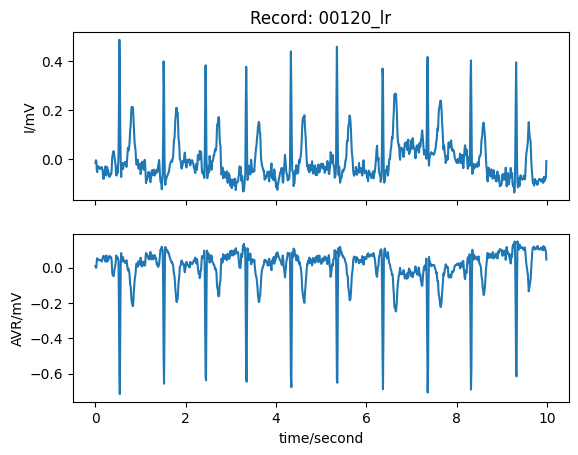

None

In [34]:
test = rdrecord(f"{path}/records100/00000/00120_lr", channels = [0,3])
display(plot.plot_wfdb(test))

In [13]:
# Add ECG numerical derived info
# Adapted the physionet code to also return one meta object dictionnary, as inspection:
sampling_rate = 100
X_df_100, meta0 = load_raw_data(df_100, sampling_rate, path)

In [14]:
u, rpeaks = nk.ecg_peaks(X_df_100[0,:,1], sampling_rate=sampling_rate)
print(rpeaks)

{'ECG_R_Peaks': array([115, 208, 300, 393, 487, 583, 679, 773, 864, 961]), 'sampling_rate': 100}


In [15]:
_rates = plot_and_rates([0,1], X_df_100, df_100, sampling_rate, rpeak_style = 'nk', plot=True)
_rates = np.mean(list(_rates.values()))

I      106.382979
II     106.382979
III    106.382979
AVR    105.509965
AVL    106.382979
AVF    118.203310
V1     106.382979
V2     106.382979
V3     106.382979
V4     106.382979
V5     106.382979
V6     106.382979
Name: heart_rates, dtype: float64

---------------------------------------------------------------------


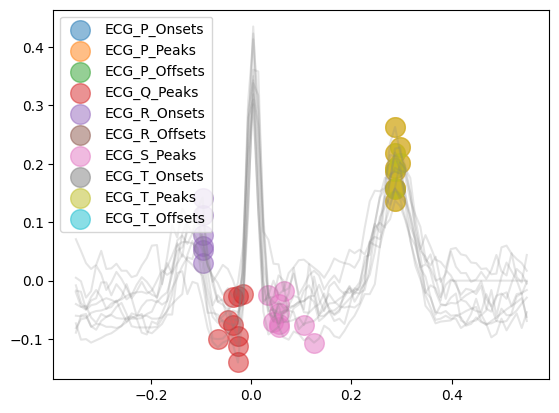

In [16]:
ecg_signal = X_df_100[0,:,1]

_, rpeaks = nk.ecg_peaks(ecg_signal, sampling_rate=sampling_rate)

signal_cwt, waves_cwt = nk.ecg_delineate(ecg_signal.copy(), 
                                         rpeaks, 
                                         sampling_rate=sampling_rate, 
                                         method="cwt", 
                                         show=True, 
                                         show_type='all')

In [17]:
print(waves_cwt)
# Make lists of R/T, T/S, T/Q
def safe_divide(x, y):
    return np.divide(x, y, out=np.zeros_like(x), where=y!=0)

tpeaks = waves_cwt['ECG_T_Peaks']
speaks = waves_cwt['ECG_S_Peaks']
qpeaks = waves_cwt['ECG_Q_Peaks']
_rpeaks = rpeaks['ECG_R_Peaks']

# Minimum length where no nans
min_len = min(len(tpeaks), len(speaks), len(qpeaks), len(_rpeaks))

s_tpeaks = np.array([ecg_signal[x] for x in tpeaks[:min_len]])
s_speaks = np.array([ecg_signal[x] for x in speaks[:min_len]])
s_qpeaks = np.array([ecg_signal[x] for x in qpeaks[:min_len]])
s_rpeaks = np.array([ecg_signal[x] for x in _rpeaks[:min_len]])

r_over_t = safe_divide(s_rpeaks, s_tpeaks)
t_over_s = safe_divide(s_tpeaks, s_speaks)
t_over_q = safe_divide(s_tpeaks, s_qpeaks)

{'ECG_P_Onsets': [nan, nan, nan, nan, nan, nan, nan, nan, nan], 'ECG_P_Peaks': [143, 236, 328, 422, 515, 611, 707, 802, 892], 'ECG_P_Offsets': [nan, nan, nan, nan, nan, nan, nan, nan, nan], 'ECG_Q_Peaks': [112, 204, 297, 389, 485, 580, 672, 770, 859, nan], 'ECG_R_Onsets': [nan, nan, 290, nan, 477, nan, 669, 763, 854, 951], 'ECG_R_Offsets': [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan], 'ECG_S_Peaks': [127, 218, 303, 399, 492, 588, 684, 777, 869, nan], 'ECG_T_Onsets': [nan, nan, nan, nan, nan, nan, nan, nan, nan], 'ECG_T_Peaks': [143, 236, 328, 422, 515, 611, 707, 802, 892], 'ECG_T_Offsets': [nan, nan, nan, nan, nan, nan, nan, nan, nan]}


In [18]:
def add_info(x):
    signal, meta = wfdb.rdsamp(f"{path}/{x.filename_lr}")
    ecg_sig = signal[:,1]
    return vals_from_ecg(ecg_sig, sampling_rate)
    
df_100["ecg_info"] = df_100.apply(add_info, axis=1)

min len:9
len ecg:1000
tpeaks:[143, 236, 328, 422, 515, 611, 707, 802, 892]
speaks:[127, 218, 303, 399, 492, 588, 684, 777, 869, nan]
qpeaks:[112, 204, 297, 389, 485, 580, 672, 770, 859, nan]
min len:6
len ecg:1000
tpeaks:[129, 259, 392, 588, nan, 773]
speaks:[103, 233, 370, 504, 638, 749, nan]
qpeaks:[97, 227, 364, 494, 624, 744, nan]


IndexError: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices

In [25]:
nan_qpeaks = np.where(np.isnan(qpeaks))
test = np.array([1,2,3,np.nan,5,np.nan,7,8,np.nan,10])

In [27]:
print(nan_qpeaks)
nan_test = np.where(np.isnan(test))
# combine q and test
total_nan = np.concatenate((nan_qpeaks[0], nan_test[0]))
print(total_nan)

(array([9]),)
[9 3 5 8]
